# PART 2!
# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption


This notebook is accompanied by a Youtube tutorial.

[WATCH THE FIRST VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [8]:
df = pd.read_csv('./rainfall.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index, format="mixed")

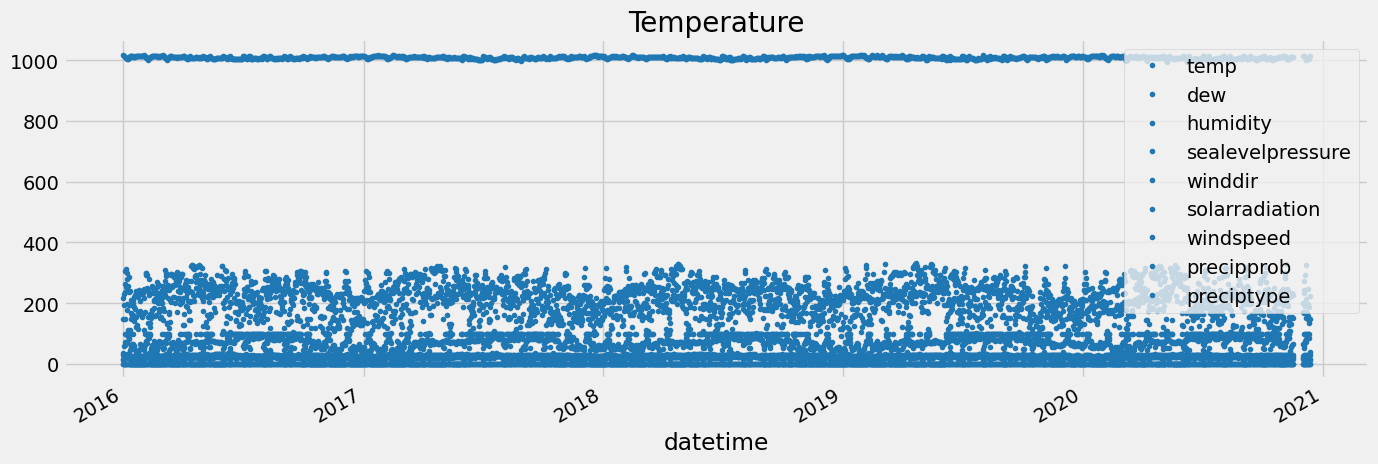

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Temperature')
plt.show()

In [10]:
def get_weather_label(row):
    if row['precipprob'] > 0:
        return 4 #'Rain'
    elif row['temp'] > 25:
        return 1 #'Hot'
    elif row['temp'] < 10:
        return 7 #'Cold'
    elif row['windspeed'] > 20:
        return 5 #'Breezy'
    elif row['humidity'] > 80:
        return 6 #'Fog'
    elif row['humidity'] > 60:
        return 3 #'Cloudy'
    else:
        return 2 #'Sunny'

In [11]:
df.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype
datetime,,,,,,,,,
2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0
2016-02-01,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0
2016-03-01,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0
2016-04-01,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0
2016-05-01,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0


In [12]:
df['weather'] = df.apply(get_weather_label, axis=1)
df.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype,weather
datetime,,,,,,,,,,
2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0,1
2016-02-01,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0,1
2016-03-01,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0,1
2016-04-01,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0,1
2016-05-01,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0,1


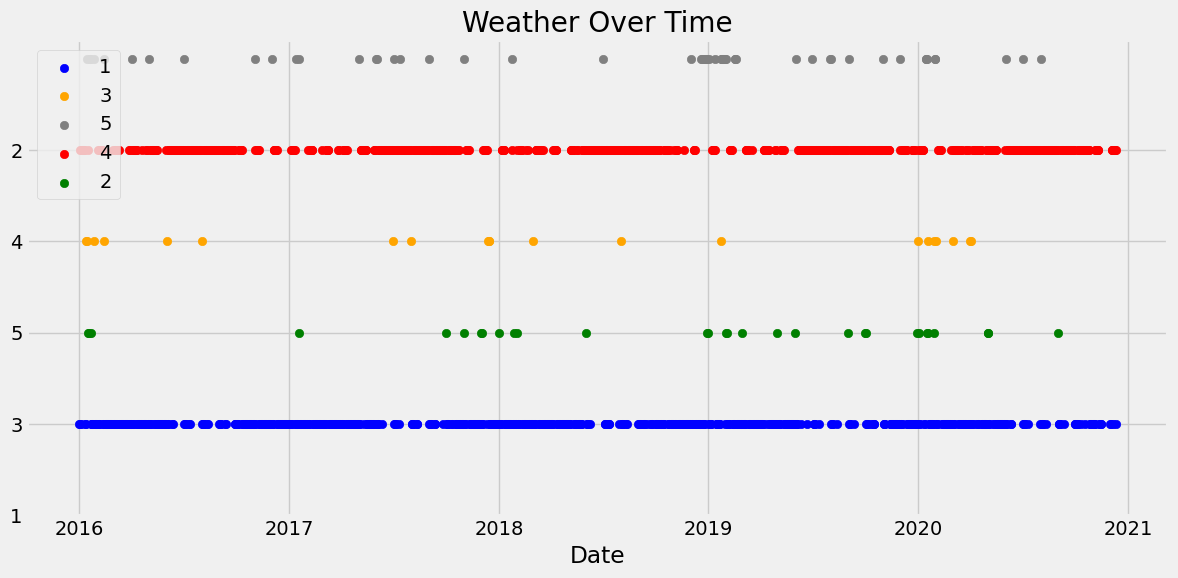

In [13]:
plt.figure(figsize=(12, 6))

# Plot each weather label with a unique color
for weather_label, color in zip(df['weather'].unique(), ['blue', 'orange', 'gray', 'red', 'green', 'purple', 'brown']):
    plt.scatter(df[df['weather'] == weather_label].index, [weather_label] * len(df[df['weather'] == weather_label]), color=color, label=weather_label)

plt.xlabel('Date')
plt.title('Weather Over Time')
plt.legend(loc='upper left')
plt.yticks(range(len(df['weather'].unique())), df['weather'].unique())  # Set y-axis ticks to display weather labels
plt.grid(True)

plt.tight_layout()
plt.show()

# 1. Outlier Analysis and removal

In [14]:
df.head()

,temp,dew,humidity,sealevelpressure,winddir,solarradiation,windspeed,precipprob,preciptype,weather
datetime,,,,,,,,,,
2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1,16.6,0,0,1
2016-02-01,26.8,13.0,44.8,1017.2,110.3,215.7,16.6,0,0,1
2016-03-01,25.5,14.6,52.8,1015.7,145.3,221.1,18.4,0,0,1
2016-04-01,26.4,13.1,46.6,1015.3,126.9,216.2,16.6,0,0,1
2016-05-01,27.1,13.5,44.9,1014.4,125.5,208.1,16.6,0,0,1


<Axes: ylabel='Frequency'>

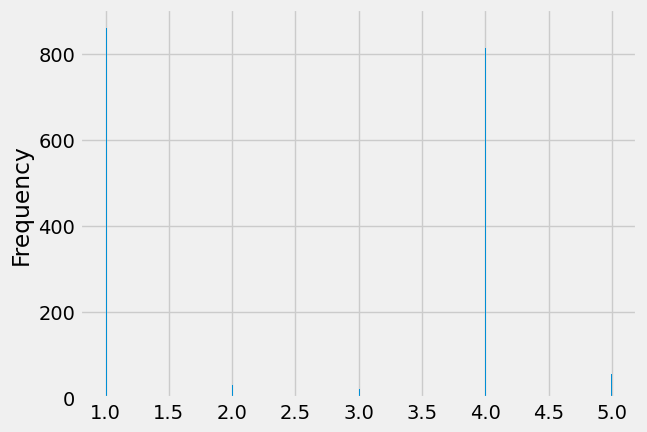

In [15]:
df['weather'].plot(kind='hist', bins=500)

In [16]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

UndefinedVariableError: name 'PJME_MW' is not defined

In [ ]:
df = df.query('PJME_MW > 19_000').copy()

# Reviewing: Train / Test Split

In [17]:
df.drop(columns=df.columns.difference(['weather']), inplace=True)
df.head()

,weather
datetime,
2016-01-01,1
2016-02-01,1
2016-03-01,1
2016-04-01,1
2016-05-01,1


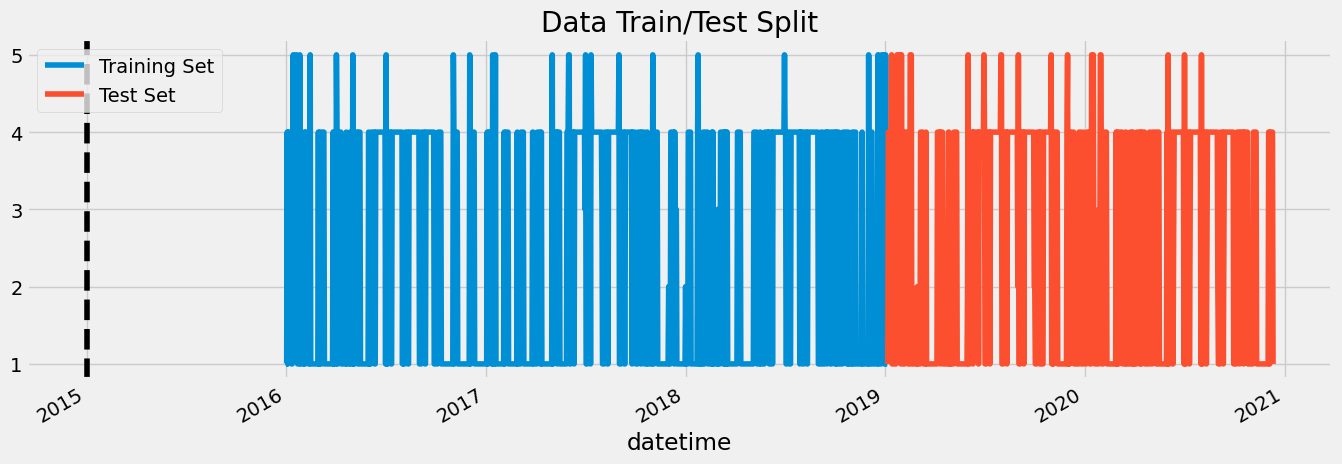

In [18]:
train = df.loc[df.index < '01-06-2019']
test = df.loc[df.index >= '01-06-2019']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [19]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

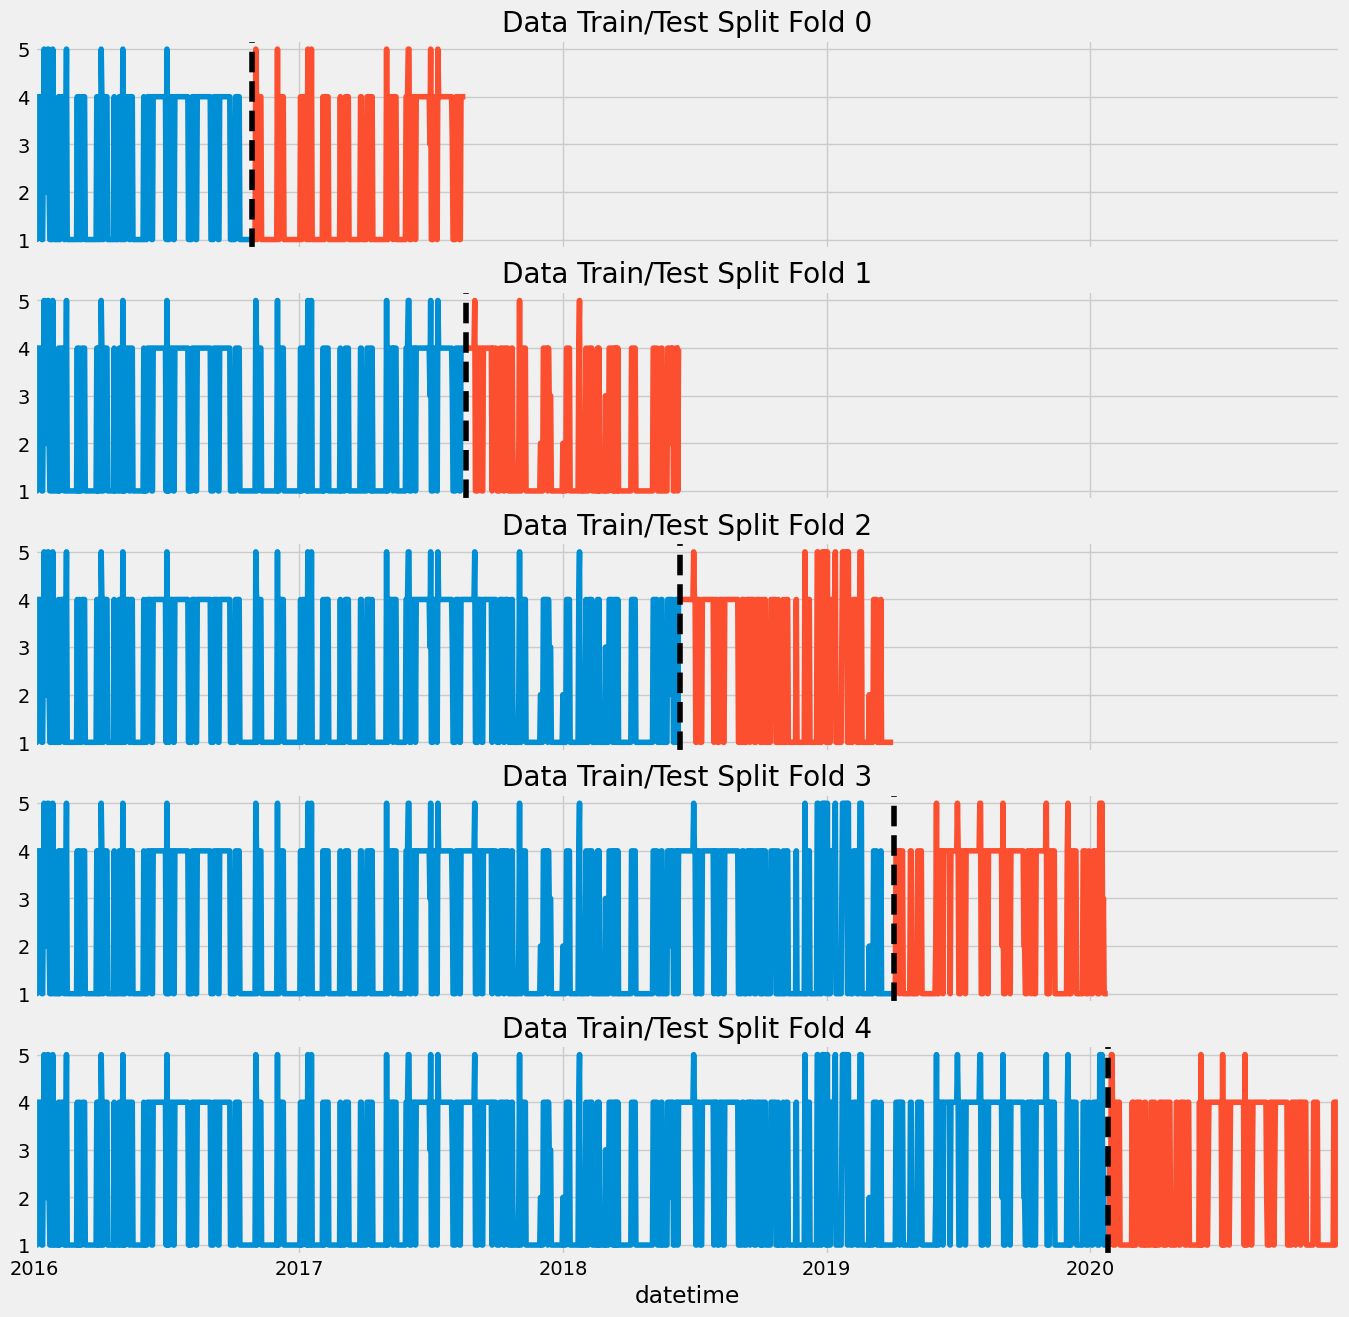

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['weather'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['weather'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [21]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [22]:
def add_lags(df):
    target_map = df['weather'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [23]:
df = add_lags(df)

In [24]:
df.head()

,weather,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
datetime,,,,,,,,,,,,
2016-01-01,1,0,4,1,1,2016,1,1,53,NaN,NaN,NaN
2016-01-02,1,0,5,1,1,2016,2,2,53,NaN,NaN,NaN
2016-01-03,4,0,6,1,1,2016,3,3,53,NaN,NaN,NaN
2016-01-04,1,0,0,1,1,2016,4,4,1,NaN,NaN,NaN
2016-01-05,4,0,1,1,1,2016,5,5,1,NaN,NaN,NaN


## Train Using Cross Validation

In [25]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'weather'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:2.53852	validation_1-rmse:2.30960
[100]	validation_0-rmse:1.46791	validation_1-rmse:1.49927
[200]	validation_0-rmse:1.19076	validation_1-rmse:1.31899
[300]	validation_0-rmse:1.09916	validation_1-rmse:1.27995
[400]	validation_0-rmse:1.04622	validation_1-rmse:1.26253


c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.99526	validation_1-rmse:1.25218
[600]	validation_0-rmse:0.94900	validation_1-rmse:1.24253
[700]	validation_0-rmse:0.91065	validation_1-rmse:1.23847
[783]	validation_0-rmse:0.87683	validation_1-rmse:1.23866
[0]	validation_0-rmse:2.42725	validation_1-rmse:2.21478
[100]	validation_0-rmse:1.44813	validation_1-rmse:1.44154
[200]	validation_0-rmse:1.21373	validation_1-rmse:1.28500
[300]	validation_0-rmse:1.13966	validation_1-rmse:1.24184
[400]	validation_0-rmse:1.09185	validation_1-rmse:1.22634

c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[500]	validation_0-rmse:1.05400	validation_1-rmse:1.22388
[600]	validation_0-rmse:1.01922	validation_1-rmse:1.22200
[673]	validation_0-rmse:0.99791	validation_1-rmse:1.22176
[0]	validation_0-rmse:2.35892	validation_1-rmse:2.56812
[100]	validation_0-rmse:1.43914	validation_1-rmse:1.62498
[200]	validation_0-rmse:1.22482	validation_1-rmse:1.44902
[300]	validation_0-rmse:1.16275	validation_1-rmse:1.42649
[387]	validation_0-rmse:1.13358	validation_1-rmse:1.42520


c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.41287	validation_1-rmse:2.75928
[100]	validation_0-rmse:1.48122	validation_1-rmse:1.72261
[200]	validation_0-rmse:1.27464	validation_1-rmse:1.47982
[300]	validation_0-rmse:1.20688	validation_1-rmse:1.42820


c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:1.17325	validation_1-rmse:1.42286
[408]	validation_0-rmse:1.17067	validation_1-rmse:1.42296
[0]	validation_0-rmse:2.48490	validation_1-rmse:2.70820
[100]	validation_0-rmse:1.50714	validation_1-rmse:1.56760
[200]	validation_0-rmse:1.29076	validation_1-rmse:1.32181
[300]	validation_0-rmse:1.22509	validation_1-rmse:1.26681


c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:1.19095	validation_1-rmse:1.25374
[500]	validation_0-rmse:1.16866	validation_1-rmse:1.24422
[582]	validation_0-rmse:1.15390	validation_1-rmse:1.24764


In [26]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.3091
Fold scores:[1.2373993415726363, 1.2207152143037943, 1.4234149576112385, 1.4205025555667126, 1.243656919876381]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [27]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'weather'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:2.52324


[100]	validation_0-rmse:1.51609
[200]	validation_0-rmse:1.29776
[300]	validation_0-rmse:1.23074


c:\Users\Steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:1.20042
[499]	validation_0-rmse:1.17982


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [28]:
df.index.max()

Timestamp('2020-12-11 00:00:00')

In [34]:
# Create future dataframe
future = pd.date_range('2020-12-11','2025-05-05', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [35]:
future_w_features = df_and_future.query('isFuture').copy()

In [39]:
future_w_features.to_csv('future_w_features.csv', index=False)

## Predict the future

In [36]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

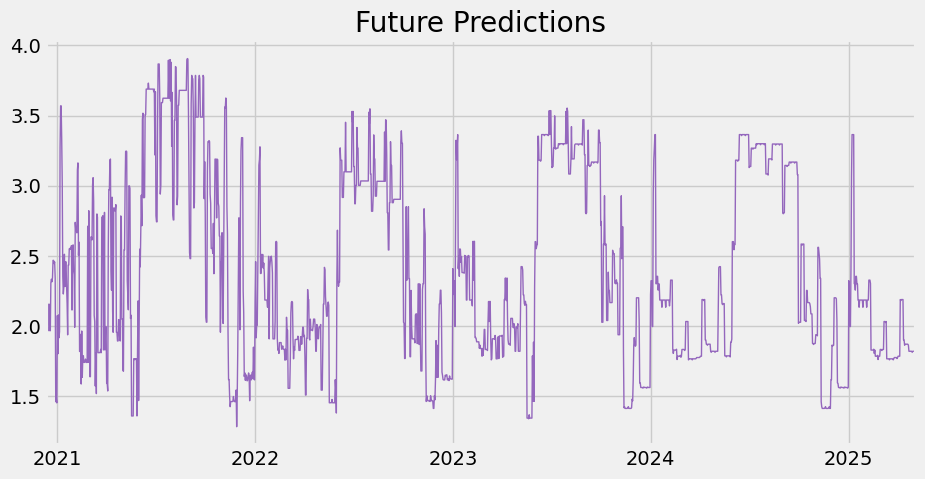

In [37]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [33]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

In [61]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'][10]
# future_w_features['pred'].plot(figsize=(10, 5),
#                                color=color_pal[4],
#                                ms=1, lw=1,
#                                title='Future Predictions')

1.4583466

In [40]:
type(future_w_features)

pandas.core.frame.DataFrame

# The End